#It's Free Time Series !
[Google Trends](https://trends.google.com) provides time series of the variation of interest of search terms over a given period. As long as you're querying for data less than 3 months old, you get daily data. If however you want older data, you get weekly time series.

This project **takes this weekly data and transforms it into daily data**. We use the [pytrends](https://pypi.org/project/pytrends/) API to extract the Google Trends time series. We then create a weekly distribution model and apply it to the weekly data.




#Imports, Variables, Functions

In [79]:
!pip install pytrends

In [80]:
import pytrends
import datetime
import pandas as pd
from pytrends.request import TrendReq
import matplotlib.pyplot as plt

In [81]:
pytrends = TrendReq()
KW_LIST = ["Blockchain","Bitcoin","Exposure","Ethereum","Libra"]

In [82]:
def build_google_trends_df(keyword_list, timeframe):
  pytrends.build_payload([keyword_list[0]], cat=0, timeframe=timeframe, geo='', gprop='')
  google_trends = pytrends.interest_over_time()[keyword_list[0]]
  for kw in keyword_list[1:]:
    pytrends.build_payload([kw], cat=0, timeframe=timeframe, geo='', gprop='')
    tmp_trends = pytrends.interest_over_time()[kw]
    google_trends = pd.concat([google_trends, tmp_trends], axis = 1)
  return google_trends


def build_weekly_repartition_model(trends_3_months_df):
  grouped_day_trends = trends_3_months_df.groupby(trends_3_months_df.index.weekday).mean()
  weekly_repartition_model = {}
  for keyword in KW_LIST :
    grouped_day_trends[keyword + "_sum"] = grouped_day_trends[keyword].sum()
    grouped_day_trends[keyword + "_weekly_contribution"] = grouped_day_trends[keyword]/grouped_day_trends[keyword+ "_sum"]
    weekly_repartition_model[keyword] = grouped_day_trends[keyword + "_weekly_contribution"]
  return weekly_repartition_model


def build_daily_trends(weekly_trends, weekly_repartition_model):
  daily_trends = pd.DataFrame(columns=KW_LIST)
  for week in weekly_trends.index:
    for day in range(6):
      date = week + datetime.timedelta(days= day)
      value_dict = {keyword: weekly_trends[keyword].loc[week]*weekly_repartition_model[keyword][day] for keyword in KW_LIST}
      row= pd.Series(value_dict, name=date)
      daily_trends = daily_trends.append(row)
  return daily_trends.rename_axis("date")

#Building the weekly distribution model

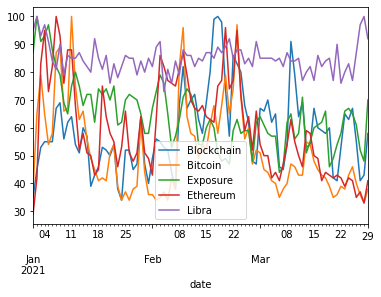

In [83]:
trends_3_months_df = build_google_trends_df(KW_LIST, 'today 3-m')
trends_3_months_df.plot()

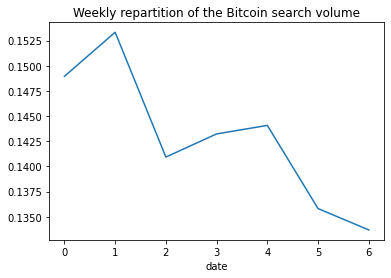

In [84]:
weekly_repartition_model = build_weekly_repartition_model(trends_3_months_df)
weekly_repartition_model['Bitcoin'].plot(title="Weekly repartition of the Bitcoin search volume")

#Applying the model to weekly data

In [85]:
weekly_trends = build_google_trends_df(KW_LIST, 'today 5-y')
weekly_trends.head()

Blockchain  Bitcoin  Exposure  Ethereum  Libra
date                                                      
2016-04-03           8        2        51         3     55
2016-04-10           8        2        57         2     57
2016-04-17           7        2        59         2     52
2016-04-24          10        3        56         2     55
2016-05-01          10        4        56         2     54

In [86]:
daily_trends = build_daily_trends(weekly_trends, weekly_repartition_model)

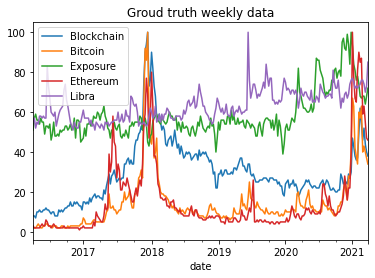

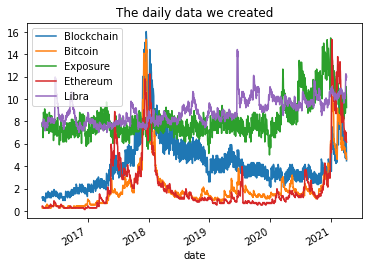

In [87]:
weekly_trends.plot(title="Groud truth weekly data")
daily_trends.plot(title="The daily data we created")

#Ways to expand on this notebook
- Evaluating the quality of the created data
- Hourly data can be queried for the last 7 days, we could use the same logic to get hourly data over a larger timeframe